# Load data

In [1]:
reddit = spark.read.parquet("/var/reddit-parquet") # these records are posts/Submissions (in PRAW) can tell by existence of 'num_comments', 'name', 'locked' & other attributes that are common to posts/Submissions 

In [3]:
type(reddit)

pyspark.sql.dataframe.DataFrame

In [4]:
len(reddit.columns)

70

In [5]:
reddit.printSchema()

root
 |-- _corrupt_record: string (nullable = true)
 |-- adserver_click_url: string (nullable = true)
 |-- adserver_imp_pixel: string (nullable = true)
 |-- approved_by: string (nullable = true)
 |-- archived: boolean (nullable = true)
 |-- author: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- banned_by: string (nullable = true)
 |-- body: string (nullable = true)
 |-- body_html: string (nullable = true)
 |-- clicked: boolean (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created: long (nullable = true)
 |-- created_utc: string (nullable = true)
 |-- disable_comments: boolean (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- domain: string (nullable = true)
 |-- downs: long (nullable = true)
 |-- edited: string (nullable = true)
 |-- from: string (nullable = true)
 |-- from_id: string (nullable = true)
 |-- from_kind: string (nullable = true)
 |-- gilded: long 

In [15]:
# %%time
# record_count = reddit.count()
record_count = 2859977347 #1% of this is +28 million

> ### The DataFrame we created has a fairly large number of columns (70), is deeply nested in several instances (up to 8 layers deep), and contains a significant number of records (+2.8 billion).

In [7]:
# select a subset of columns for EDA

these_cols = [
    "id",
    "parent_id",
    "subreddit",
    "author",
    "created_utc",
    "body",
    "num_comments",
    "score"
] # "created" is not as populated as created_utc, better to use created_utc

> ### For our initial EDA we primarily care about the columns indicated above so we'll subset the data appropriately.

In [8]:
cols_df = reddit.select(these_cols)
cols_df.dtypes

[('id', 'string'),
 ('parent_id', 'string'),
 ('subreddit', 'string'),
 ('author', 'string'),
 ('created_utc', 'string'),
 ('body', 'string'),
 ('num_comments', 'bigint'),
 ('score', 'bigint')]

> ### It's worthwhile to check the data types of the columns. You may notice that "created_utc" is a string. It actually contains the created date in Unix time/Epoch time (the number of seconds since January 1, 1970). We'll want to convert that to a more human readable format.

# Created date

In [9]:
from pyspark.sql.functions import from_unixtime

In [10]:
# add new col showing just created year
cols_df = cols_df.withColumn(
    "created_utc_year", 
    from_unixtime(
        cols_df["created_utc"], 
        "yyyy" # full timestamp: yyyy-MM-dd HH:mm:ss.SS
    )
)

In [11]:
%%time
years_df = cols_df.groupby("created_utc_year").count()
years_df.orderBy("created_utc_year").show()

+----------------+---------+
|created_utc_year|    count|
+----------------+---------+
|            null|        1|
|            2005|     1086|
|            2006|   419341|
|            2007|  2745064|
|            2008|  9773673|
|            2009| 23726352|
|            2010| 55571522|
|            2011|138398080|
|            2012|289689090|
|            2013|441953216|
|            2014|584765776|
|            2015|738997386|
|            2016|573936760|
+----------------+---------+

CPU times: user 18.8 ms, sys: 7.56 ms, total: 26.3 ms
Wall time: 1min 1s


> ### The data covers 11 years from 2005 to 2016. Reddit was founded in 2005 and we can see a hint of the platform's growth just in terms of the number of posts in the dataset.

In [12]:
null_count = cols_df[cols_df["body"].isNull()].count()

In [16]:
null_count

279383793

In [17]:
round((float(null_count)/record_count)*100,2)

9.77

> ### While there are a large number of records with null values in "body" (+279 million), this is only ~10% of the overall data.

In [18]:
clean_df = cols_df[
    (cols_df["created_utc_year"].isNotNull())&
    (cols_df["body"].isNotNull())
]

In [19]:
# %%time
# clean_df.count() # 2,580,593,554

> ### We are still left with +2.5 billion records!
> ### However, using all the records would be excessive and time-intensive.
> ### A stratified, one percent sample of the total should be sufficient. 

In [20]:
# these_years = clean_df.select("created_utc_year").distinct()
# yearly_portion = these_years.count()/100.0
# fraction_dict = {str(i["created_utc_year"]):yearly_portion for i in these_years.collect()}

# <font color='magenta'>1% Sample [START HERE]</font>

In [21]:
# # stratified sample
# one_perct_df = clean_df.sampleBy(
#     col = "created_utc_year",
#     fractions = fraction_dict
# )

# one_perct_df.write.parquet("one_perct_sample.parquet")
one_perct_df = spark.read.parquet("one_perct_sample.parquet")

In [22]:
# %%time
# one_perct_df.count() # ~300+ million

In [23]:
%%time
one_perct_df.groupby("created_utc_year").count().orderBy("created_utc_year").show()

+----------------+--------+
|created_utc_year|   count|
+----------------+--------+
|            2005|     121|
|            2006|   49806|
|            2007|  295787|
|            2008|  869100|
|            2009| 2267457|
|            2010| 5823105|
|            2011|14809391|
|            2012|31257433|
|            2013|48294467|
|            2014|63861731|
|            2015|80257957|
|            2016|62024775|
+----------------+--------+

CPU times: user 12.6 ms, sys: 1.46 ms, total: 14.1 ms
Wall time: 18.6 s


> ### This 1% stratified sample is off by ~10%. The actual yearly counts in the sample are greater than the expected yearly counts by an order of magnitude.

# Subreddits (using 1% sample)

In [24]:
one_perct_df = one_perct_df.withColumn(
    "created_utc_yearMonthDay", 
    from_unixtime(
        one_perct_df["created_utc"], 
        "yyyy-MM-dd" # full timestamp: yyyy-MM-dd HH:mm:ss.SS
    )
)

In [25]:
from pyspark.sql.functions import length

In [26]:
one_perct_df = one_perct_df.withColumn(
    "body_len",
    length(one_perct_df["body"])
)

In [27]:
%%time
yearsMonthDay_df = one_perct_df.groupby(["subreddit","created_utc_yearMonthDay"]).count()

avg_post_df = yearsMonthDay_df.groupby("subreddit").avg()
avg_post_df.orderBy("avg(count)", ascending = False).show(10)

+---------------+------------------+
|      subreddit|        avg(count)|
+---------------+------------------+
|      AskReddit| 9625.758874320434|
|          funny|2303.9110468850354|
|leagueoflegends|2222.1374468085105|
|           pics|2138.2788033099937|
|  AdviceAnimals|1866.3457497612226|
|     The_Donald|1725.2114882506528|
|            nfl|1411.4748329621382|
|         gaming|1408.0648119841028|
|       politics|1341.2522631261315|
|   pcmasterrace|1336.1035767511178|
+---------------+------------------+
only showing top 10 rows

CPU times: user 30.8 ms, sys: 0 ns, total: 30.8 ms
Wall time: 33.1 s


In [28]:
%%time
max_post_df = yearsMonthDay_df.groupby("subreddit").max()
max_post_df.orderBy("max(count)", ascending = False).show(10)

+-----------------+----------+
|        subreddit|max(count)|
+-----------------+----------+
|        AskReddit|     25487|
|         politics|     18517|
|              nfl|     14949|
|           gaming|     13775|
|     pcmasterrace|     13304|
|millionairemakers|     12874|
|             news|     12298|
|              nba|     12160|
|    SquaredCircle|     12033|
|              CFB|     11263|
+-----------------+----------+
only showing top 10 rows

CPU times: user 8.17 ms, sys: 8.85 ms, total: 17 ms
Wall time: 15.5 s


> ### Are these counts for daily posts reliable? How to double check?

In [29]:
these_subreddits = [
    "worldnews", "news", "AskCulinary",
    "AskHistorians", "howto", "todayilearned",
    "conspiracy", "MilitaryConspiracy", "PedoGate",
    "FalseFlagWatch", "skeptic", "politicalfactchecking",
    "MensRights", "MRActivism", "glasgow",
    "melbourne", "travel", "photography"
]

In [30]:
temp_df = yearsMonthDay_df.filter(yearsMonthDay_df.subreddit.isin(these_subreddits))

In [31]:
pd_df = temp_df.select(["subreddit","count"]).toPandas()

In [32]:
pd_df.shape

(33624, 2)

In [33]:
pd_df.sample(5)

,subreddit,count
22439,news,6
94,glasgow,4
12718,photography,107
3597,photography,20
2559,travel,38


> ### These daily counts are drastically less than those indicated above.

In [34]:
import matplotlib.pyplot as plt

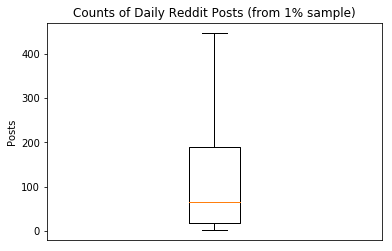

In [35]:
plt.boxplot(x = pd_df["count"], showfliers = False);
plt.tick_params(labelbottom = False, bottom = False)
plt.ylabel("Posts");
plt.title(s = "Counts of Daily Reddit Posts (from 1% sample)");

# Can still evaluate distributions of scores & body_len for certain (common) Subreddits

In [36]:
check = one_perct_df.filter(one_perct_df["subreddit"].isin(these_subreddits)).select(["subreddit","score","body_len"])

In [37]:
check.count() # this is too large to move to a pandas DF

10699242

In [38]:
check.columns

['subreddit', 'score', 'body_len']

In [39]:
score_df = check.groupBy('subreddit').avg()

In [42]:
score_df.show(3)

+-------------+------------------+------------------+
|    subreddit|        avg(score)|     avg(body_len)|
+-------------+------------------+------------------+
|       travel|2.5056377168045487|262.33010508831893|
|   MensRights| 4.161007972805426| 305.9944603645102|
|todayilearned| 9.111728716471747|159.46736597184463|
+-------------+------------------+------------------+
only showing top 3 rows



In [41]:
# plt.boxplot(x = check_df["score"], showfliers = False);
# plt.tick_params(labelbottom = False, bottom = False)
# plt.ylabel("Posts");
# plt.title(s = "Scores of Daily Reddit Posts (from select Subreddits in 1% sample)");